# Buck Converter with L-C input filter

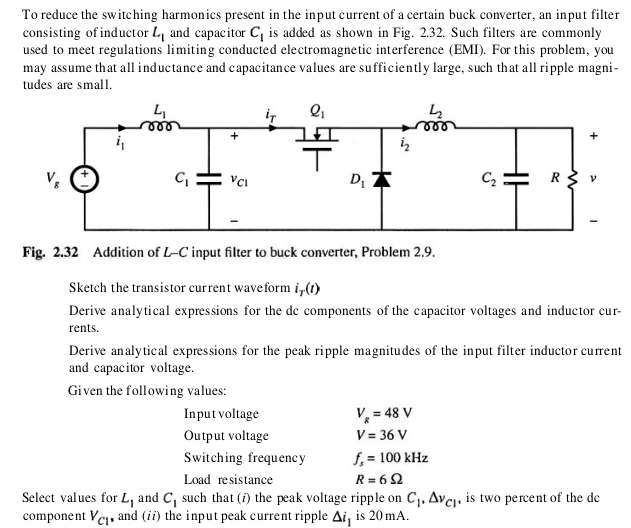

#### The input filter in the problem statement is entirely undamped, and that is not a very realistic circuit to use in real life. The filter cap voltage will exhibit a lot of ringing when the top switch opens (Q1 above). So, let's include some damping elements in the analysis:

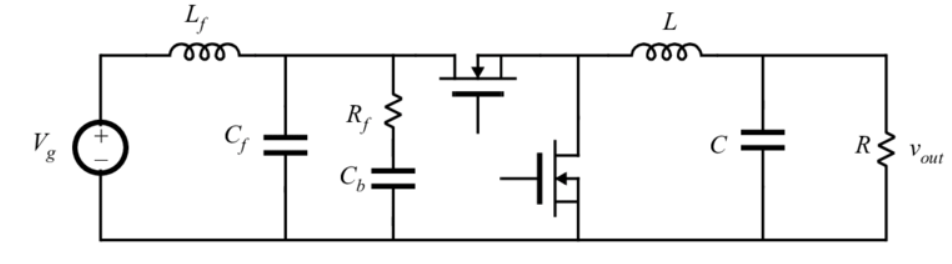

#### Above shows the circuit for the following analysis. The goal is to create a framework for analysing the circuit that will enable easy designs, and a means of testing design choices (simulating). The problem statement above give some rough numbers to start with, and says that all ripple magnitudes are sufficiently small, such that the small ripple approximation may be made. 

#### The small-ripple approximation, applied to the input filter, predicts zero L1 ripple current. This is because both side of the inductor are connected to nodes with the same DC value. The filter capacitor does see different currents between parts of the cycle: L1 current for 0<t<DTs, and L1 + L2 current for DTs < t < Ts (ignoring Rf and Cb current)

#### If one first accounts for the different filter capacitor currents, from different switch states, to determine varying capacitor voltage, and then writing down the input filter inductor ripple current, the result is a system of differential equations. This method becomes intractible, and it makes more sense to use a state-space representation. The model below is created with three state space representations, corresponding to the three circuits that result from the different switch states. The final conditions of one state are the initial conditions of the next. 

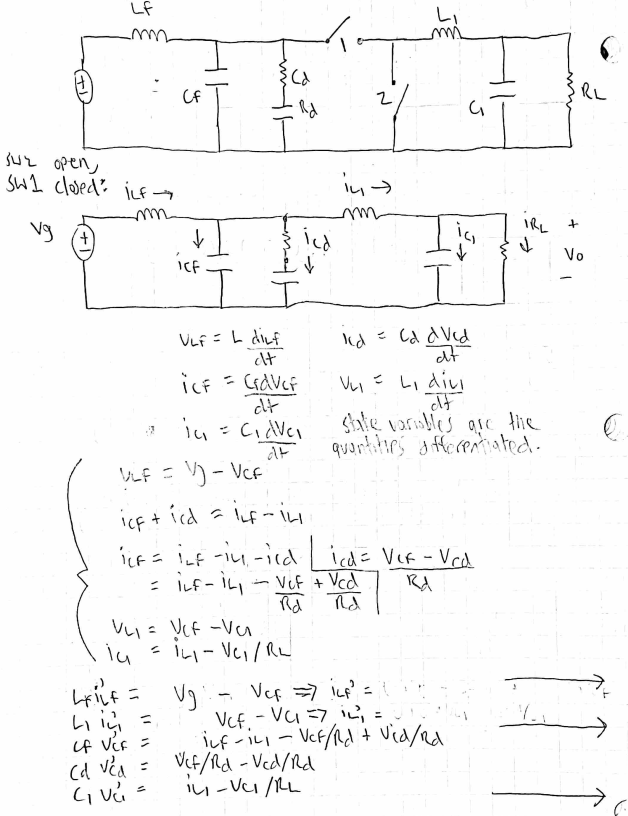
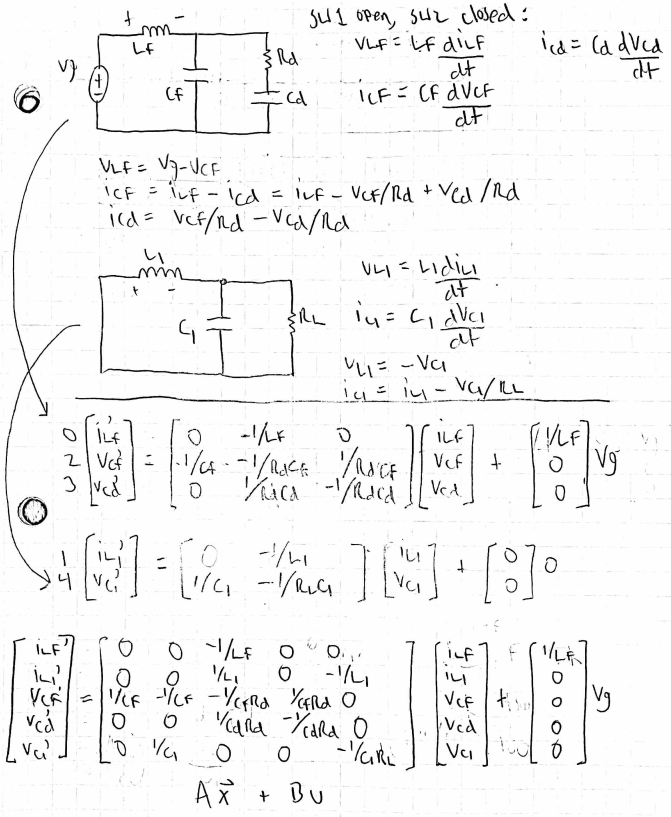

In [1]:
import sympy
from sympy.core.symbol import symbols, Symbol

from sympy.printing import latex, pprint
from sympy import Symbol, simplify
from sympy import Matrix
from sympy import dsolve, Function, Derivative, integrate, diff
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter

from math import log10
from PyLTSpice import LTSpice_RawRead

import logging
from ipywidgets import FloatSlider, interact, interactive
from converter5 import *

from control import *

Found Numpy. WIll be used for storing data


In [2]:

Lf = symbols('L_f')
L1 = symbols('L_1')
Cf = symbols('C_f')
C1 = symbols('C_1')
Cd = symbols('C_d')
Vg = symbols('V_g')
Rd = symbols('R_d')
Rl = symbols('R_l')


iLf = symbols('iL_f')
iL1 = symbols('iL_1')
il = symbols('i_l')
vCf = symbols('v_{Cf}')
vCd = symbols('v_{Cd}')
vC1 = symbols('v_{C1}')

t = symbols('t') #time variable

#These last symbols are used for the input filter problem. 
s = symbols('s') #Laplace Transform variable
j = sympy.sqrt(-1)
w = symbols('omega') #radian frequency
Z_Lf = s*Lf 
Z_Cf = 1/(s*Cf)
Z_Cd = 1/(s*Cd)

In [3]:
A1 = Matrix([[0, 0, -1/Lf, 0, 0],
           [0, 0, 1/L1, 0, -1/L1],
           [1/Cf, -1/Cf, -1/(Cf*Rd), 1/(Cf*Rd), 0],
           [0, 0, 1/(Cd*Rd), -1/(Cd*Rd), 0],
           [0, 1/C1, 0, 0, -1/(Rl*C1)]])

A2 = Matrix([[0, -1/Lf, 0],
            [1/Cf, -1/(Rd*Cf), 1/(Rd*Cf)],
            [0, 1/(Rd*Cd), -1/(Rd*Cd)]])

A3 = Matrix([[0, -1/L1],
            [1/C1, -1/(Rl*C1)]])

In [4]:
myprint(symbols('A_1'), A1)
myprint(symbols('A_2'), A2)
myprint(symbols('A_3'), A3)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
B1 = Matrix([[1/Lf], [0], [0], [0], [0]])
B2 = Matrix([[1/Lf], [0], [0]])
B3 = Matrix([[0], [0]])

In [6]:
myprint(symbols('B_1'), B1)
myprint(symbols('B_2'), B2)
myprint(symbols('B_3'), B3)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### The state variables are:  

%display latex
$$\left [ x_{1}\ x_{2}\ x_{3}\ x_{4}\ x_{5} \right ]^{T}
= \left [i_{Lf}\ i_{L1}\ v_{Cf}\ v_{Cd}\ v_{C1}  \right]^{T}$$

In [7]:
D1 = 0
D2 = 0
D3 = 0
#The C matrices are not really used below. 
C1_ = np.identity(5)
C2_ = np.identity(3)
C3_ = np.identity(2)

In [8]:
subs = {Vg:10, Cf: 1e-6, Lf:1e-6, Rd: .4, Cd:31e-6, Rl:1, L1:12.5e-6, C1:1e-6 }
#transition from Sympy to Numpy:
A1 = np.array(A1.subs(subs)).astype(np.float64)
B1 = np.array(B1.subs(subs)).astype(np.float64)
A2 = np.array(A2.subs(subs)).astype(np.float64)
B2 = np.array(B2.subs(subs)).astype(np.float64)
A3 = np.array(A3.subs(subs)).astype(np.float64)
B3 = np.array(B3.subs(subs)).astype(np.float64)

#### In the cell above, the components are assigned values. How were these chosen? This exercise is more about the method, than the numbers. The problem statement at the top gives some starting points, but I chose the numbers based on a few preferences. 

#### 500kHz is reasonable switching frequency, and a 1ohm load makes for easy math. If those are chosen first, it places a maximum on the output LC corner frequency. The output LC corner frequency should be at least 10x less than the switching frequency, so it can adequately filter the switch node square wave. With a 1ohm load, Vg = 10, and duty cycle of .5, the load current is 10V*.5 / 1ohm = 5A. The size of the output inductor determines the current ripple through it, and I arbitrarily size the inductor such that the ripple current is .2A (.4A peak to peak). Then, L2  = (Vg-Vout)*DTs/(2 *delta_IL2) = (5*.5*2us/(2*.2) = 5*1e-6*2.5 = 12.5uH, and C = 1/((fc * 2* pi)^2*L) = 1/((45e3 * 2* pi)^2*12.5e-6) = 1uF, where the 45kHz is less than the switching frequency divided by 10. 

#### The input filter component sizing is actually more complicated. It is a third order filter, and finding an analytical expression for peak voltages and currents is messy. Please see "DampedInputFilter.ipynb" for that analysis.

In [9]:
s1 = StateSpace(A1, B1, C1_, D1) #whole ckt, switch 1 closed, switch 2 open
s2 = StateSpace(A2, B2, C2_, D2) #first half of ckt, switch 1 open, switch 2 closed
s3 = StateSpace(A3, B3, C3_, D3) # second half of ckt, switch 1 open, switch 2 closed

In [10]:
p=0
periods = 50
samples_per_period =41
fs = 500e3
ts = 1/fs
d = .54
t = np.linspace(0, ts*periods, periods*samples_per_period)
u = 10*np.ones(t.shape[0])
x_sim = np.zeros((5, samples_per_period*periods))
indices = np.array(range(samples_per_period*periods))

for p in range(periods):
    
    d_idx_s = p*samples_per_period
    d_idx_f = int(d*samples_per_period+1+p*samples_per_period)
    dp_idx_s = d_idx_f - 1
    dp_idx_f = (p+1)*samples_per_period+1
    
    td = t[d_idx_s:d_idx_f] #doesn't actually include d_idx_f!
    ud = u[d_idx_s:d_idx_f]
    
    tdp = t[dp_idx_s:dp_idx_f]
    udp = u[dp_idx_s:dp_idx_f]
    
    if p == 0:
        s1_X0 = np.zeros(5)
    else: 
        s1_X0 = x_sim[:, d_idx_s]

    T, y, x_sim[:,d_idx_s:d_idx_f] = forced_response(s1, T=td, U=ud, X0=s1_X0, return_x=True ) 

    s2_X0 = x_sim[[0, 2 ,3], dp_idx_s]
    s3_X0 = x_sim[[1, 4], dp_idx_s]

    T, y, x_sim[[0, 2, 3], dp_idx_s:dp_idx_f] = forced_response(s2, T=tdp, U=udp, X0=s2_X0 , return_x=True )
    T, y, x_sim[[1, 4], dp_idx_s:dp_idx_f] = forced_response(s3, T=tdp, X0=s3_X0 , return_x=True ) 

#### Challenge for you: run the LTspice simulation, and compare results to the state space representation. 

In [11]:
raw = os.path.join(os.getcwd(), 'problem2-9.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
Vc = LTR.get_trace("V(vc1)").get_wave()
iT = LTR.get_trace("V(vcf)").get_wave()
iL = LTR.get_trace("I(L1)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()

Normal access


AttributeError: 'NoneType' object has no attribute 'get_wave'

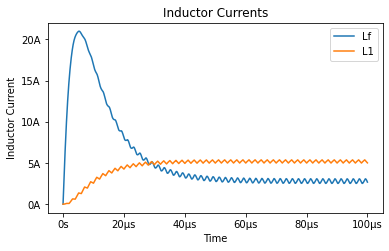

In [12]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={'title':'Inductor Currents'}, figsize=(6,3.5))
ax.plot(t, x_sim[0,:], label = 'Lf')
ax.plot(t, x_sim[1,], label = 'L1')
ax.yaxis.set_major_formatter(EngFormatter(unit='A', places=0, sep=''))
major_formatter= EngFormatter(unit='s', places=0, sep='')
ax.set_xlabel('Time')
ax.set_ylabel('Inductor Current')
ax.xaxis.set_major_formatter(major_formatter)
ax.legend()

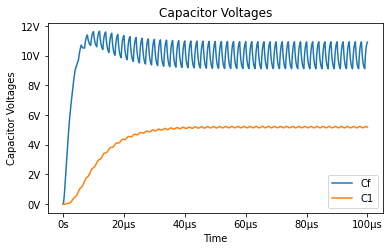

In [13]:
fig, ax = plt.subplots(subplot_kw={'title':'Capacitor Voltages'}, figsize=(6,3.5))
ax.plot(t, x_sim[2,:], label='Cf')
ax.plot(t, x_sim[4,:], label = 'C1')
ax.yaxis.set_major_formatter(EngFormatter(unit='V', places=0, sep=''))
ax.xaxis.set_major_formatter(major_formatter)
ax.set_xlabel('Time')
ax.set_ylabel('Capacitor Voltages')
ax.legend()

In [14]:
#Let's calculate the loss in the damping resistor, over the very last period. 
VRd_RMS = np.sqrt(np.mean((x_sim[2,:][-samples_per_period:] - x_sim[3,:][-samples_per_period:])**2))
print(f'Damping Resistor Loss = {VRd_RMS**2/subs[Rd]:.3f}W')

Damping Resistor Loss = 0.954W
